# A deep analysis of multiple machine learning methods on stroke prediction

Dataset: https://www.kaggle.com/fedesoriano/stroke-prediction-dataset

In [ ]:
!pip install -U scikit-learn

     |████████████████████████████████| 22.3MB 64.8MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import *

In [5]:
healthInfo = pd.read_csv("/content/drive/MyDrive/GE1356DS/code/healthcare-dataset-stroke-data.csv",sep = ',')
healthInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [6]:
# original data
healthInfo.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data cleaning & Visualization

In [7]:
# drop ID column
healthInfo.drop('id', axis = 1, inplace=True)
healthInfo.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


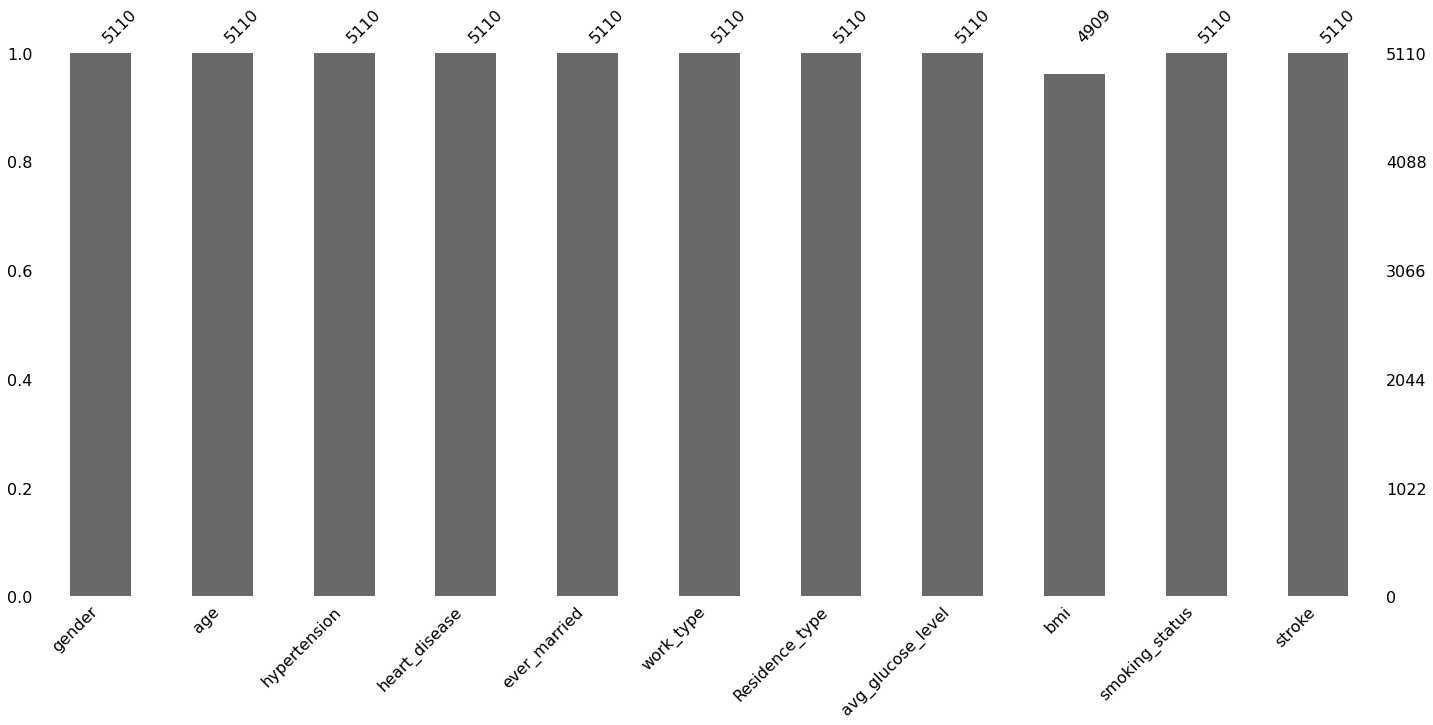

In [8]:
msno.bar(healthInfo)

In [9]:
# found 201 N/A in bmi column
healthInfo.isnull().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
# fill N/A bmi with its mean
healthInfo['bmi'].fillna(healthInfo['bmi'].mean(), inplace=True)
healthInfo.isna().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
healthInfo.shape

(5110, 11)

In [12]:
healthInfo['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

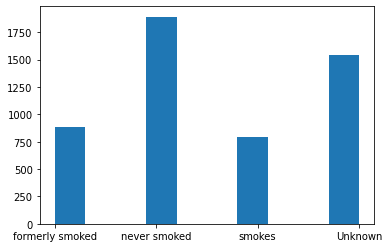

In [13]:
plt.hist(healthInfo['smoking_status'])
plt.show()

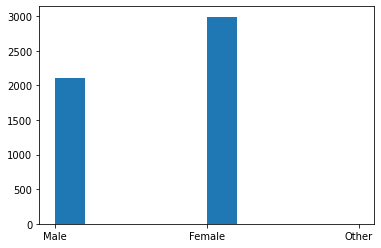

In [14]:
plt.hist(healthInfo['gender'])
plt.show()

In [15]:
healthInfo['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [16]:
# remove the column where gender's value is 'Other'
healthInfo = healthInfo[healthInfo['gender'] != "Other"]

In [17]:
healthInfo['gender'].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

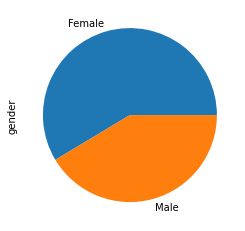

In [18]:
healthInfo.gender.value_counts().plot(kind='pie')

In [19]:
healthInfo.shape

(5109, 11)

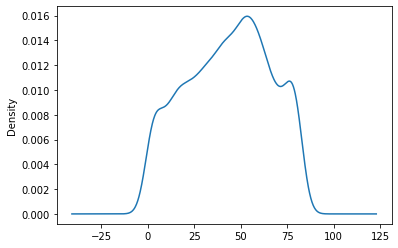

In [20]:
healthInfo['age'].plot(kind='kde')
plt.show()

In [21]:
# seperate columns with values of integers and strings
df_object = healthInfo.select_dtypes(include="object")
df_number = healthInfo.select_dtypes(exclude="object")

df_object

,gender,ever_married,work_type,Residence_type,smoking_status
0,Male,Yes,Private,Urban,formerly smoked
1,Female,Yes,Self-employed,Rural,never smoked
2,Male,Yes,Private,Rural,never smoked
3,Female,Yes,Private,Urban,smokes
4,Female,Yes,Self-employed,Rural,never smoked
...,...,...,...,...,...
5105,Female,Yes,Private,Urban,never smoked
5106,Female,Yes,Self-employed,Urban,never smoked
5107,Female,Yes,Self-employed,Rural,never smoked
5108,Male,Yes,Private,Rural,formerly smoked


In [22]:
# replace nominal attributes to numerical ones by encoding
# concatenate both types of columns
label = LabelEncoder()
df_object = df_object.astype(str).apply(label.fit_transform)

data = pd.concat([df_object, df_number], axis = 1)
data

,gender,ever_married,work_type,Residence_type,smoking_status,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,1,1,2,1,1,67.0,0,1,228.69,36.600000,1
1,0,1,3,0,2,61.0,0,0,202.21,28.893237,1
2,1,1,2,0,2,80.0,0,1,105.92,32.500000,1
3,0,1,2,1,3,49.0,0,0,171.23,34.400000,1
4,0,1,3,0,2,79.0,1,0,174.12,24.000000,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,0,1,2,1,2,80.0,1,0,83.75,28.893237,0
5106,0,1,3,1,2,81.0,0,0,125.20,40.000000,0
5107,0,1,3,0,2,35.0,0,0,82.99,30.600000,0
5108,1,1,2,0,1,51.0,0,0,166.29,25.600000,0


In [34]:
def get_stacked_bar_chart_age(df, column):
    df_pct = df.groupby([column, 'stroke'])['age'].count()
    df_pct = df_pct.unstack()    
    return df_pct.plot.bar(stacked=True, figsize=(7,7), width=1);

In [35]:
data_visualize_age = data.copy()
data_visualize_age['age_bin'] = pd.cut(data_visualize_age['age'], np.arange(0, 95, 5))

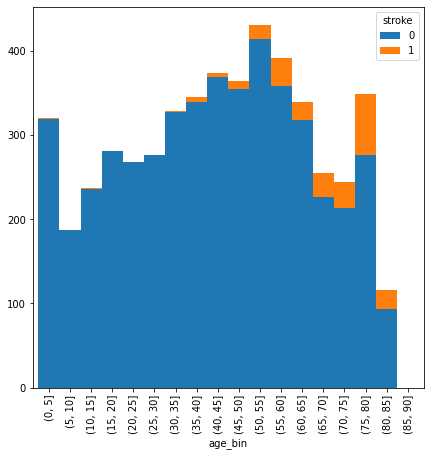

In [36]:
get_stacked_bar_chart(data_visualize_age, 'age_bin')

In [38]:
def get_stacked_bar_chart_bmi(df, column):
    df_pct = df.groupby([column, 'stroke'])['bmi'].count()
    df_pct = df_pct.unstack()    
    return df_pct.plot.bar(stacked=True, figsize=(7,7), width=1);

In [41]:
data_visualize_bmi = data.copy()
data_visualize_bmi['bmi'] = pd.cut(data_visualize_bmi['bmi'], np.arange(10, 70, 2))

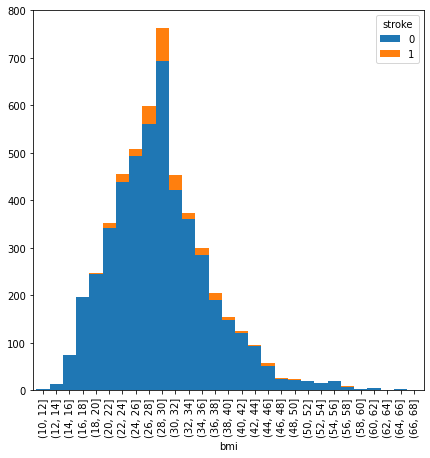

In [42]:
get_stacked_bar_chart(data_visualize_bmi, 'bmi')

In [43]:
def get_stacked_bar_chart_glucose(df, column):
    df_pct = df.groupby([column, 'stroke'])['avg_glucose_level'].count()
    df_pct = df_pct.unstack()    
    return df_pct.plot.bar(stacked=True, figsize=(7,7), width=1);

In [48]:
data_visualize_glucose = data.copy()
data_visualize_glucose['avg_glucose_level'] = pd.cut(data_visualize_glucose['avg_glucose_level'], np.arange(40, 300, 10))

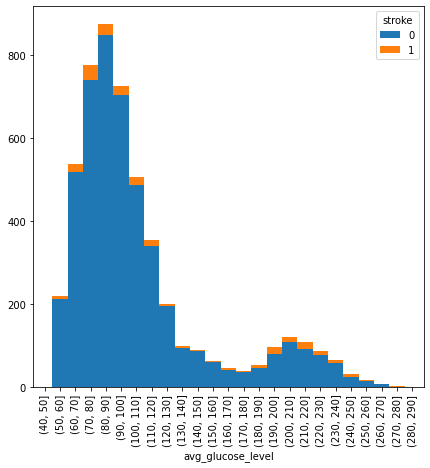

In [49]:
get_stacked_bar_chart_glucose(data_visualize_glucose, 'avg_glucose_level')

In [ ]:
# seperate attributes and ground truth
X = data.drop(['stroke'],axis = 1)
y = data.stroke

In [ ]:
# Standardize features by removing the mean and scaling to unit variance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X 

array([[ 1.18979109e+00,  7.23678181e-01, -1.53851772e-01, ...,
         4.18459909e+00,  2.70644995e+00,  1.00104066e+00],
       [-8.40483686e-01,  7.23678181e-01,  7.63334580e-01, ...,
        -2.38971519e-01,  2.12165168e+00, -1.65111256e-04],
       [ 1.18979109e+00,  7.23678181e-01, -1.53851772e-01, ...,
         4.18459909e+00, -4.86741416e-03,  4.68398925e-01],
       ...,
       [-8.40483686e-01,  7.23678181e-01,  7.63334580e-01, ...,
        -2.38971519e-01, -5.11265616e-01,  2.21564950e-01],
       [ 1.18979109e+00,  7.23678181e-01, -1.53851772e-01, ...,
        -2.38971519e-01,  1.32837547e+00, -4.27998141e-01],
       [-8.40483686e-01,  7.23678181e-01, -1.98822448e+00, ...,
        -2.38971519e-01, -4.60692049e-01, -3.50050570e-01]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=66, shuffle =True)

#Splitted Data
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)

X_train shape is  (4087, 10)
X_test shape is  (1022, 10)
y_train shape is  (4087,)
y_test shape is  (1022,)


# Training

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, C=1)
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.9500978473581213

## Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing=0)
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.8825831702544031

In [ ]:
gnb = GaussianNB(var_smoothing=100)
gnb.fit(X_train, y_train)
gnb.score(X_test, y_test)

0.9500978473581213

## K nearest neighbors

When k is equal to 1, the knn model has the lowest accuracy. When searching among different k values, the model performs best when k is 8.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.913894324853229

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9432485322896281

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.9500978473581213

In [ ]:
# test a number of neighbors to see which one yields the highest accuracy
paramgrid = {'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11]}
clf = model_selection.GridSearchCV(neighbors.KNeighborsClassifier(), param_grid=paramgrid, cv=10, n_jobs=-1)

clf.fit(X_train,y_train)
print(clf.best_params_)

{'n_neighbors': 8}


In [ ]:
# train and test the KNN model with k = 8
neighbors_model = neighbors.KNeighborsClassifier(n_neighbors = clf.best_params_["n_neighbors"])
neighbors_model.fit(X_train,y_train)
print("train_acc",neighbors_model.score(X_train,y_train))
print("test_acc",neighbors_model.score(X_test,y_test))

train_acc 0.9515537068754588
test_acc 0.9500978473581213


## Genetic Algorithm with Artificial Neural Network optimization

In [ ]:
import random
import logging
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

logging.basicConfig(level=logging.DEBUG,
                    format='%(asctime)s %(message)s',
                    handlers=[logging.FileHandler("ann_test.log"),
                              logging.StreamHandler()])

class ANN(Sequential):
    
    def __init__(self, child_weights=None):
        super().__init__()

        if child_weights is None:
            layer1 = Dense(10, input_shape=(10,), activation='sigmoid')
            layer2 = Dense(1, activation='sigmoid')
            self.add(layer1)
            self.add(layer2)
        else:
            self.add(
                Dense(
                    10,
                    input_shape=(10,),
                    activation='sigmoid',
                    weights=[child_weights[0], np.ones(10)])
                )
            self.add(
                Dense(
                    1,
                    activation='sigmoid',
                    weights=[child_weights[1], np.zeros(1)])
            )

    def forward_propagation(self, train_feature, train_label):
        predict_label = self.predict(train_feature)
        self.fitness = accuracy_score(train_label, predict_label.round())

def crossover(nn1, nn2):
    
    nn1_weights = []
    nn2_weights = []
    child_weights = []

    for layer in nn1.layers:
        nn1_weights.append(layer.get_weights()[0])

    for layer in nn2.layers:
        nn2_weights.append(layer.get_weights()[0])

    for i in range(len(nn1_weights)):
        # Get single point to split the matrix in parents based on # of cols
        split = random.randint(0, np.shape(nn1_weights[i])[1]-1)
        # Iterate through after a single point and set the remaing cols to nn_2
        for j in range(split, np.shape(nn1_weights[i])[1]-1):
            nn1_weights[i][:, j] = nn2_weights[i][:, j]

        child_weights.append(nn1_weights[i])

    mutation(child_weights)

    child = ANN(child_weights)
    return child

def mutation(child_weights):
    selection = random.randint(0, len(child_weights)-1)
    mut = random.uniform(0, 1)
    if mut <= .05:
        child_weights[selection] *= random.randint(2, 5)
    else:
        pass

In [ ]:
# train feature
train_feature = X_train
# train label
train_label = y_train
# test feature
test_feature = X_test
# test label
test_label = y_test

# store all active ANNs
networks = []
pool = []
# Generation counter
generation = 0
# Initial Population
population = 10
for i in range(population):
    networks.append(ANN())
# Track Max Fitness
max_fitness = 0
# Store Max Fitness Weights
optimal_weights = []

epochs = 100
# Evolution Loop
for i in range(epochs):
    generation += 1
    logging.debug("Generation: " + str(generation) + "\r\n")

    for ann in networks:
        # Propagate to calculate fitness score
        ann.forward_propagation(train_feature, train_label)
        # Add to pool after calculating fitness
        pool.append(ann)

    # Clear for propagation of next children
    networks.clear()

    # Sort anns by fitness
    pool = sorted(pool, key=lambda x: x.fitness)
    pool.reverse()

    # Find Max Fitness and Log Associated Weights
    for i in range(len(pool)):
        if pool[i].fitness > max_fitness:
            max_fitness = pool[i].fitness

            logging.debug("Max Fitness: " + str(max_fitness) + "\r\n")

            # Iterate through layers, get weights, and append to optimal
            optimal_weights = []
            for layer in pool[i].layers:
                optimal_weights.append(layer.get_weights()[0])
            logging.debug('optimal_weights: ' + str(optimal_weights)+"\r\n")

    # Crossover: top 5 randomly select 2 partners
    for i in range(5):
        for j in range(2):
            # Create a child and add to networks
            temp = crossover(pool[i], random.choice(pool))
            # Add to networks to calculate fitness score next iteration
            networks.append(temp)

# Create a Genetic Neural Network with optimal initial weights
ann = ANN(optimal_weights)
predict_label = ann.predict(test_feature)
print('Test Accuracy: %.2f' % accuracy_score(test_label, predict_label.round()))

2021-04-10 12:52:17,217 Generation: 1

2021-04-10 12:52:18,816 Max Fitness: 0.9515537068754588

2021-04-10 12:52:18,821 optimal_weights: [array([[ 0.10313207,  0.50480103,  0.35185218,  0.518111  ,  0.5281637 ,
         0.07419056,  0.2746272 ,  0.11536157,  0.4624436 , -0.32885328],
       [ 0.01791644,  0.49265575, -0.02963191,  0.12790012,  0.44982892,
        -0.07696694, -0.32391328,  0.29909647,  0.04636031, -0.42999792],
       [-0.20080334, -0.042485  ,  0.4953549 ,  0.13616973, -0.10276145,
        -0.1278393 ,  0.3532189 ,  0.27581722,  0.14183342, -0.20720485],
       [-0.0006941 , -0.5421004 ,  0.41681892, -0.37810895,  0.02450871,
        -0.18225616,  0.12148076,  0.34013212, -0.22571847, -0.45388076],
       [-0.30314863,  0.38590187,  0.02263951,  0.30813104, -0.41837865,
         0.13414693,  0.025868  , -0.10177499,  0.29760647, -0.0702374 ],
       [-0.194365  , -0.04256076,  0.34858328,  0.41451824, -0.0494419 ,
        -0.4888122 ,  0.02549392, -0.5289948 , -0.3102

Test Accuracy: 0.95
